# Setup & Data Import

In [177]:
# !pip install yfinance

# !pip install pycaret
# !pip install markupsafe==2.0.1
# !pip install Jinja2

In [178]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
btc_ticker = yf.Ticker('BTC-USD')
btc = btc_ticker.history(period="max")
btc = btc.drop(columns=['Dividends', 'Stock Splits'])

In [180]:
btc.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-08-28,20041.035156,20139.054688,19616.814453,19616.814453,24366810591
2022-08-29,19615.154297,20357.462891,19600.785156,20297.994141,32637854078
2022-08-30,20298.611328,20542.644531,19617.640625,19796.808594,34483360283
2022-08-31,19799.582031,20420.990234,19799.582031,20049.763672,33225232872
2022-09-01,20068.558594,20192.179688,19935.248047,19936.281250,31269920768


# Data Preparation

In [181]:
monthly_close = btc.groupby(btc.index.month)['Close'].tail(1)

In [182]:
# btc.resample('M', origin='end').mean().tail(10)

In [183]:
month_close_df = btc.copy()[btc.index.is_month_end]
month_close_df.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)

month_close_df.rename(columns={'Close':'month_close'}, inplace=True)


month_close_df

,month_close
Date,
2014-09-30,386.944000
2014-10-31,338.321014
2014-11-30,378.046997
2014-12-31,320.192993
2015-01-31,217.464005
...,...
2022-04-30,37714.875000
2022-05-31,31792.310547
2022-06-30,19784.726562


In [184]:
btc_month_mean = btc.resample('M').mean()
btc_month_mean.rename(columns={'Open':'month_ave_open', 'High':'month_ave_high', 'Low':'month_ave_low', 'Close':'month_ave_close', 'Volume':'month_ave_volume'}, inplace=True)
btc_month_mean.tail()


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume
Date,,,,,
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10
2022-08-31,22471.866557,22870.607863,22075.572203,22366.266318,2.884492e+10
2022-09-30,20068.558594,20192.179688,19935.248047,19936.281250,3.126992e+10


In [185]:
btc_month_mean['month_ave_close_shift'] = btc_month_mean['month_ave_close'].shift(-1)
# btc_month_mean.dropna(inplace=True)
btc_month_mean

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift
Date,,,,,,
2014-09-30,412.654003,421.104422,398.174641,407.182428,2.934864e+07,364.148873
2014-10-31,365.748000,374.314260,354.856645,364.148873,2.912885e+07,366.099799
2014-11-30,364.850235,376.494235,357.241831,366.099799,2.199111e+07,341.267871
2014-12-31,343.074836,347.487129,336.565775,341.267871,1.784201e+07,248.782547
2015-01-31,251.799905,261.391583,240.495550,248.782547,3.544555e+07,234.153645
...,...,...,...,...,...,...
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10,22366.266318


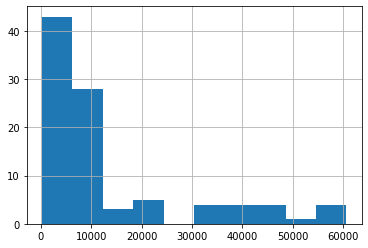

In [186]:
btc_month_mean['month_ave_close_shift'].hist()

In [187]:
btc_month_mean['month_ave_close_shift_diff'] = btc_month_mean['month_ave_close_shift'].diff()
btc_month_mean.dropna(inplace=True)

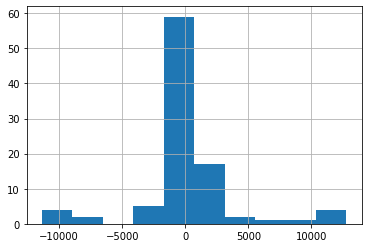

In [188]:
btc_month_mean['month_ave_close_shift_diff'].hist()

Dickey–Fuller test: p=0.103240


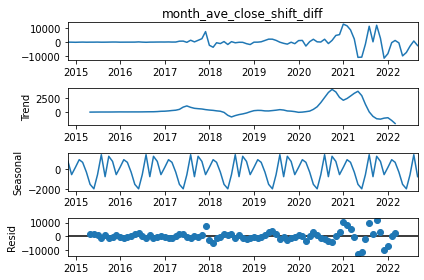

In [189]:
seasonal_decompose(btc_month_mean['month_ave_close_shift_diff']).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month_mean['month_ave_close_shift_diff'])[1])

In [190]:
btc_month_mean.head(20)


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff
Date,,,,,,,
2014-10-31,365.748000,374.314260,354.856645,364.148873,2.912885e+07,366.099799,1.950926
2014-11-30,364.850235,376.494235,357.241831,366.099799,2.199111e+07,341.267871,-24.831928
2014-12-31,343.074836,347.487129,336.565775,341.267871,1.784201e+07,248.782547,-92.485323
2015-01-31,251.799905,261.391583,240.495550,248.782547,3.544555e+07,234.153645,-14.628903
2015-02-28,232.821856,240.211430,227.769678,234.153645,2.541138e+07,269.042259,34.888614
2015-03-31,269.278419,274.850999,263.134162,269.042259,3.093865e+07,235.491534,-33.550725
2015-04-30,235.708668,238.957098,231.734033,235.491534,2.241129e+07,236.997001,1.505467
2015-05-31,237.161806,239.563161,234.939388,236.997001,1.832654e+07,238.081766,1.084765
2015-06-30,236.941433,240.127034,235.028233,238.081766,2.099267e+07,279.563740,41.481974


In [191]:
btc_month_mean['month_ave_close_shift_diff_percent'] = None

for i in range(1, len(btc_month_mean)):
  btc_month_mean['month_ave_close_shift_diff_percent'][i] = \
  (btc_month_mean['month_ave_close_shift'][i] - btc_month_mean['month_ave_close_shift'][i-1]) / btc_month_mean['month_ave_close_shift'][i-1]

btc_month_mean.dropna(inplace=True)

In [192]:
btc_month_mean

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2014-11-30,364.850235,376.494235,357.241831,366.099799,2.199111e+07,341.267871,-24.831928,-0.067828
2014-12-31,343.074836,347.487129,336.565775,341.267871,1.784201e+07,248.782547,-92.485323,-0.271005
2015-01-31,251.799905,261.391583,240.495550,248.782547,3.544555e+07,234.153645,-14.628903,-0.058802
2015-02-28,232.821856,240.211430,227.769678,234.153645,2.541138e+07,269.042259,34.888614,0.148999
2015-03-31,269.278419,274.850999,263.134162,269.042259,3.093865e+07,235.491534,-33.550725,-0.124704
...,...,...,...,...,...,...,...,...
2022-04-30,41694.653646,42328.085156,40805.150260,41435.319661,2.767053e+10,31706.105217,-9729.214445,-0.234805
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482,-7322.419735,-0.230947
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843,-2844.431639,-0.116653


!! Stationary

Dickey–Fuller test: p=0.000000


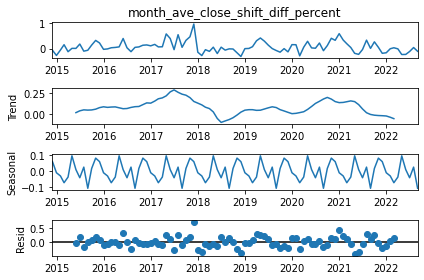

In [193]:
seasonal_decompose(btc_month_mean['month_ave_close_shift_diff_percent']).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month_mean['month_ave_close_shift_diff_percent'])[1])

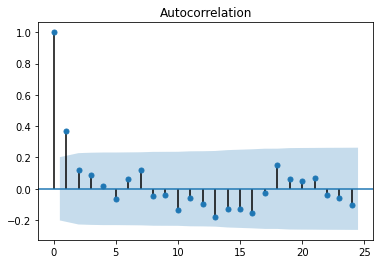

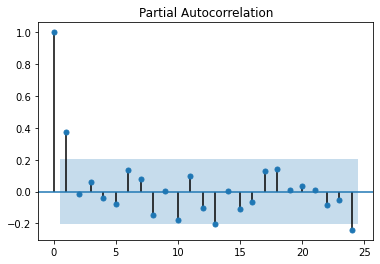

In [194]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(btc_month_mean['month_ave_close_shift_diff_percent'], lags=24);
plot_pacf(btc_month_mean['month_ave_close_shift_diff_percent'], lags=24);

## Train/Test Split + Scale Data

In [195]:
train_test_split = int(btc_month_mean.shape[0] * 0.75)
train = btc_month_mean.copy().iloc[:train_test_split]
test = btc_month_mean.copy().iloc[train_test_split:]
train.shape, test.shape

((70, 8), (24, 8))

In [196]:
train.columns

Index(['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_close',
       'month_ave_volume', 'month_ave_close_shift',
       'month_ave_close_shift_diff', 'month_ave_close_shift_diff_percent'],
      dtype='object')

In [197]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

#hide warnings
train_scaled = pd.DataFrame()
test_scaled = pd.DataFrame()

train_scaled[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']] = \
  scaler.fit_transform(train[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']])
test_scaled[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']] = \
  scaler.transform(test[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']])

train_scaled.index = train.index
test_scaled.index = test.index

display(train_scaled.head())
display(test_scaled.tail())

,month_ave_open,month_ave_high,month_ave_low,month_ave_volume,month_ave_close,month_ave_close_shift_diff_percent
Date,,,,,,
2014-11-30,0.008836,0.008840,0.009269,0.000100,0.008798,0.192411
2014-12-31,0.007379,0.007006,0.007789,0.000000,0.007149,0.032382
2015-01-31,0.001270,0.001562,0.000911,0.000423,0.001008,0.199520
2015-02-28,0.000000,0.000223,0.000000,0.000182,0.000037,0.363191
2015-03-31,0.002440,0.002413,0.002532,0.000315,0.002354,0.147613


,month_ave_open,month_ave_high,month_ave_low,month_ave_volume,month_ave_close,month_ave_close_shift_diff_percent
Date,,,,,,
2022-04-30,2.774778,2.661495,2.905062,0.664579,2.735716,0.060894
2022-05-31,2.119331,2.048247,2.196297,0.856768,2.089714,0.063933
2022-06-30,1.643011,1.580276,1.684191,0.739741,1.603520,0.153954
2022-07-31,1.418240,1.376894,1.484209,0.718689,1.414655,0.276076
2022-08-31,1.488318,1.431173,1.564153,0.692803,1.469567,0.160262


In [198]:
X_train = train_scaled.copy().drop(columns=['month_ave_close_shift_diff_percent'])
y_train = train_scaled.copy()['month_ave_close_shift_diff_percent']

X_test = test_scaled.copy().drop(columns=['month_ave_close_shift_diff_percent'])
y_test = test_scaled.copy()['month_ave_close_shift_diff_percent']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70, 5), (70,), (24, 5), (24,))

In [199]:
X_train.head(20)

,month_ave_open,month_ave_high,month_ave_low,month_ave_volume,month_ave_close
Date,,,,,
2014-11-30,0.008836,0.008840,0.009269,0.000100,0.008798
2014-12-31,0.007379,0.007006,0.007789,0.000000,0.007149
2015-01-31,0.001270,0.001562,0.000911,0.000423,0.001008
2015-02-28,0.000000,0.000223,0.000000,0.000182,0.000037
2015-03-31,0.002440,0.002413,0.002532,0.000315,0.002354
2015-04-30,0.000193,0.000144,0.000284,0.000110,0.000126
2015-05-31,0.000290,0.000182,0.000513,0.000012,0.000226
2015-06-30,0.000276,0.000218,0.000520,0.000076,0.000298
2015-07-31,0.003081,0.003000,0.003365,0.000346,0.003052


# LinearRegression (static window)

In [200]:
lr = LinearRegression()
lr.fit(X_train, y_train) 
lr.score(X_train, y_train) 

0.4130837625034667

In [201]:
X_test_predict = lr.predict(X_test)

X_test_predict_df = pd.DataFrame(X_test_predict, index=X_test.index, columns=['Y_PRED'])
X_test_predict_df

,Y_PRED
Date,
2020-09-30,0.122398
2020-10-31,0.334955
2020-11-30,0.373815
2020-12-31,0.541257
2021-01-31,-0.257381
2021-02-28,0.615860
2021-03-31,0.372402
2021-04-30,-0.336695
2021-05-31,-0.685087


## Reassemble data frame with prediction

In [202]:
predict_df = test.merge(X_test_predict_df, how='left', on='Date')
predict_df

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED
Date,,,,,,,,,
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072,0.122398
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335,0.334955
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645,0.373815
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287,0.541257
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123,-0.257381
2021-02-28,45874.967215,47710.414621,44197.377302,46306.798968,8.096975e+10,54998.008695,8691.209727,0.187688,0.615860
2021-03-31,54544.678175,56250.979083,52964.134703,54998.008695,5.423175e+10,57206.720052,2208.711358,0.04016,0.372402
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,6.148273e+10,46443.286668,-10763.433384,-0.18815,-0.336695
2021-05-31,47105.828503,48775.041835,44434.530620,46443.286668,6.376108e+10,35845.154687,-10598.131981,-0.228195,-0.685087


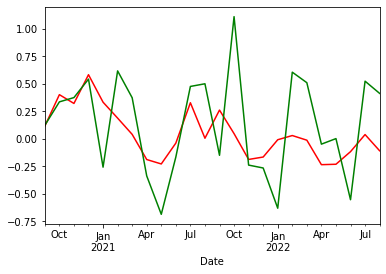

In [203]:
predict_df['month_ave_close_shift_diff_percent'].plot(c='red')
predict_df['Y_PRED'].plot(c='green')

In [204]:
#merge actual close with the dataframe
# predict_df = predict_df.merge(month_close_df, how='left', left_index=True, right_index=True)
predict_df


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED
Date,,,,,,,,,
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072,0.122398
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335,0.334955
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645,0.373815
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287,0.541257
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123,-0.257381
2021-02-28,45874.967215,47710.414621,44197.377302,46306.798968,8.096975e+10,54998.008695,8691.209727,0.187688,0.615860
2021-03-31,54544.678175,56250.979083,52964.134703,54998.008695,5.423175e+10,57206.720052,2208.711358,0.04016,0.372402
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,6.148273e+10,46443.286668,-10763.433384,-0.18815,-0.336695
2021-05-31,47105.828503,48775.041835,44434.530620,46443.286668,6.376108e+10,35845.154687,-10598.131981,-0.228195,-0.685087


### append_gain_loss

In [205]:
#temp
month_close_df.tail()

,month_close
Date,
2022-04-30,37714.875000
2022-05-31,31792.310547
2022-06-30,19784.726562
2022-07-31,23336.896484
2022-08-31,20049.763672


In [206]:
#hide chain warning
pd.options.mode.chained_assignment = None

In [207]:
def append_gain_loss(df, debug=False):

  df = df.merge(month_close_df, how='left', left_index=True, right_index=True)
  if debug:
    display(df.tail())

  df['gain_loss'] = None
  for i in range(1, len(df)):
    df['gain_loss'][i] = df['month_close'][i] - df['month_close'][i-1]

  df.dropna(inplace=True)
  return df

predict_df = append_gain_loss(predict_df)
predict_df

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED,month_close,gain_loss
Date,,,,,,,,,,,
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335,0.334955,13780.995117,2996.503906
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645,0.373815,19625.835938,5844.84082
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287,0.541257,29001.720703,9375.884766
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123,-0.257381,33114.359375,4112.638672
2021-02-28,45874.967215,47710.414621,44197.377302,46306.798968,8.096975e+10,54998.008695,8691.209727,0.187688,0.615860,45137.769531,12023.410156
2021-03-31,54544.678175,56250.979083,52964.134703,54998.008695,5.423175e+10,57206.720052,2208.711358,0.04016,0.372402,58918.832031,13781.0625
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,6.148273e+10,46443.286668,-10763.433384,-0.18815,-0.336695,57750.175781,-1168.65625
2021-05-31,47105.828503,48775.041835,44434.530620,46443.286668,6.376108e+10,35845.154687,-10598.131981,-0.228195,-0.685087,37332.855469,-20417.320312
2021-06-30,35920.546940,37094.880143,34375.803060,35845.154687,3.965492e+10,34444.973790,-1400.180897,-0.039062,-0.165558,35040.835938,-2292.019531


## Evaluate strategy

### if Y_PRED > 0

In [208]:
def calc_gain_loss(df, threshold, column, debug=False):
  gain_loss = []
  for index, row in df.iterrows():
    if row[column] > threshold:
      if debug:
        print(f'{index}::{row[column]}')

      # gain_loss.append(row['Close_shift'] - row['Close'])
      gain_loss.append(row['gain_loss'])
      
  if debug:
    display(gain_loss)
    print(f'GAIN/LOSS: {sum(gain_loss)}')
    
  return sum(gain_loss)  

In [209]:
gain_loss = calc_gain_loss(predict_df, 0.0, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss: 75073.6396484375


### if Y_PRED > .1


In [210]:
gain_loss = calc_gain_loss(predict_df, 0.1, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss: 80996.2041015625


### if Y_PRED > .20

In [211]:
gain_loss = calc_gain_loss(predict_df, 0.2, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss: 80996.2041015625


In [212]:
predict_df.shape

(23, 11)

In [213]:
#find residuals and P values
from statsmodels.api import OLS

ols = OLS(y_train, X_train).fit()

In [214]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     month_ave_close_shift_diff_percent   R-squared (uncentered):                   0.498
Model:                                            OLS   Adj. R-squared (uncentered):              0.459
Method:                                 Least Squares   F-statistic:                              12.87
Date:                                Thu, 01 Sep 2022   Prob (F-statistic):                    1.05e-08
Time:                                        07:17:20   Log-Likelihood:                        -0.62710
No. Observations:                                  70   AIC:                                      11.25
Df Residuals:                                      65   BIC:                                      22.50
Df Model:                                           5                                                  
Covariance Type:                            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
month_ave_open     -85.3666     18.876     -4.523      0.000    -123.064     -47.669
month_ave_high      82.7441     27.196      3.043      0.003      28.431     137.058
month_ave_low       62.0640     18.267      3.398      0.001      25.581      98.547
month_ave_volume    -0.2290      0.174     -1.317      0.193      -0.577       0.118
month_ave_close    -59.0953     31.294     -1.888      0.063    -121.594       3.403
==============================================================================
Omnibus:                        0.730   Durbin-Watson:                   0.574
Prob(Omnibus):                  0.694   Jarque-Bera (JB):                0.807
Skew:                          -0.108   Prob(JB):                        0.668
Kurtosis:                       2.521   Cond. No.                     1.28e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

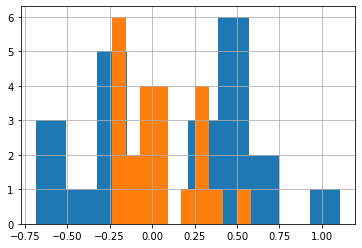

In [215]:
predict_df['Y_PRED'].hist()
predict_df['month_ave_close_shift_diff_percent'].hist()

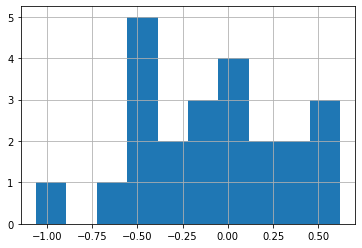

In [216]:
(predict_df['month_ave_close_shift_diff_percent']-predict_df['Y_PRED']).hist()

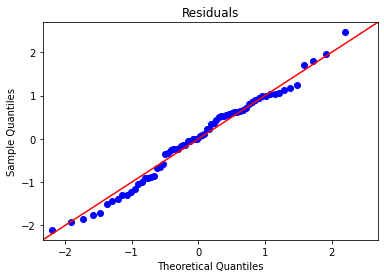

In [217]:
sm.qqplot(ols.resid, fit=True, line='45')
plt.title('Residuals')
plt.show()

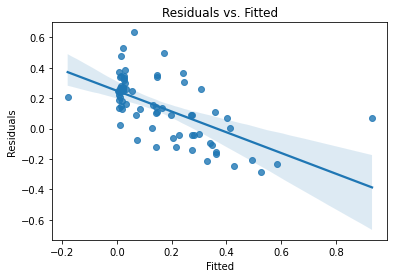

In [218]:
sns.regplot(x=ols.fittedvalues, y=ols.resid)
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

# Linear Regression (Sliding 'X' month window)


In [219]:
btc_month_mean.tail()

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2022-04-30,41694.653646,42328.085156,40805.150260,41435.319661,2.767053e+10,31706.105217,-9729.214445,-0.234805
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482,-7322.419735,-0.230947
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843,-2844.431639,-0.116653
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10,22366.266318,827.012475,0.038396
2022-08-31,22471.866557,22870.607863,22075.572203,22366.266318,2.884492e+10,19936.281250,-2429.985068,-0.108645


In [220]:
def calc_sliding_window(window_size, input_df, debug=False):
  predict_df = pd.DataFrame(columns=['Y_PRED'])
  # btc_month_mean.shape

  for i in range(window_size, input_df.shape[0]+1):

    window_data = input_df[i-window_size:i]
    if debug:
      print(f'{i-window_size}->{i}')
      display(window_data)

    X = window_data.copy()[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_close', 'month_ave_volume']]

    X_train = X[:X.shape[0]-1]
    X_pred = X[X.shape[0]-1:]

    y = window_data['month_ave_close_shift_diff_percent']
    y_train = y[:X.shape[0]-1]

    lr = LinearRegression()
    lr.fit(X_train, y_train) 
    y_pred = lr.predict(X_pred)[0]

    y_pred_df = pd.DataFrame(data=[y_pred], columns=['Y_PRED'], index=[X_pred.index[0]])
    predict_df = pd.concat([predict_df, pd.DataFrame(y_pred_df)], ignore_index=False)

  return predict_df

In [221]:
test_df = calc_sliding_window(48, btc_month_mean, False)
test_df

test_df = append_gain_loss(test_df)
gain_loss = calc_gain_loss(test_df, 0, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss: 82763.087890625


In [222]:
test_df = calc_sliding_window(48, btc_month_mean, False)
test_df

test_df = append_gain_loss(test_df)
gain_loss = calc_gain_loss(test_df, 0.33, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss: 44393.7861328125


In [223]:
test_df = calc_sliding_window(48, btc_month_mean, False)
test_df

test_df = append_gain_loss(test_df)
gain_loss = calc_gain_loss(test_df, 0.5, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss: 29551.47265625


In [226]:
# window_size = 24
# predict_df = pd.DataFrame(columns=['Y_PRED'])
# # btc_month_mean.shape

# for i in range(window_size, btc_month_mean.shape[0]+1):
#   print(f'{i-window_size}->{i}')

#   window_data = btc_month_mean[i-window_size:i]
#   display(window_data)

#   X = window_data.copy()[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_close', 'month_ave_volume']]

#   X_train = X[:X.shape[0]-1]
#   X_pred = X[X.shape[0]-1:]

#   y = window_data['month_ave_close_shift_diff_percent']
#   y_train = y[:X.shape[0]-1]

#   lr = LinearRegression()
#   lr.fit(X_train, y_train) 
#   y_pred = lr.predict(X_pred)[0]

#   y_pred_df = pd.DataFrame(data=[y_pred], columns=['Y_PRED'], index=[X_pred.index[0]])
#   predict_df = pd.concat([predict_df, pd.DataFrame(y_pred_df)], ignore_index=False)

#   # break
# predict_df.tail(20)

predict_df = calc_sliding_window(24, btc_month_mean, False)
predict_df


,Y_PRED
2016-10-31,0.072304
2016-11-30,-0.060967
2016-12-31,0.204789
2017-01-31,-0.306923
2017-02-28,0.177075
...,...
2022-04-30,-0.156535
2022-05-31,-0.022516
2022-06-30,-0.000664
2022-07-31,0.162727


### append_gain_loss(predict_df)

In [229]:
predict_df = append_gain_loss(predict_df)

In [230]:
gain_loss = calc_gain_loss(predict_df, 0, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss: 82890.32818603516


In [231]:
gain_loss = calc_gain_loss(predict_df, 0.1, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss: 70228.86529541016


In [232]:
gain_loss = calc_gain_loss(predict_df, 0.2, 'Y_PRED')
print(f'gain_loss: {gain_loss}')

gain_loss: 63588.06494140625


## Loop over window size and gain % options

In [252]:
window_sizes = [6, 12, 24, 36, 48, 60]
gain_loss_percents = [0, .1, .2, .3]

result_df = pd.DataFrame(columns=['window', 'percent', 'gain_loss'])

for window_size in window_sizes:
  for gain_loss_percent in gain_loss_percents:

    test_df = calc_sliding_window(window_size, btc_month_mean, False)

    test_df = append_gain_loss(test_df)
    gain_loss = calc_gain_loss(test_df, gain_loss_percent, 'Y_PRED')

    loop_df = pd.DataFrame(data=[[window_size, gain_loss_percent, gain_loss]], columns=['window', 'percent', 'gain_loss'])
    result_df = pd.concat([result_df, loop_df], ignore_index=True)

result_df

,window,percent,gain_loss
0,6,0,43856.538895
1,6,0.1,37943.330444
2,6,0.2,38860.899139
3,6,0.3,26351.897400
4,12,0,76859.950104
5,12,0.1,64792.655579
6,12,0.2,53073.027527
7,12,0.3,40559.405457
8,24,0,82890.328186
9,24,0.1,70228.865295


In [253]:
result_df.sort_values('gain_loss', ascending=False)

,window,percent,gain_loss
20,60,0,87984.991211
12,36,0,84988.592285
8,24,0,82890.328186
16,48,0,82763.087891
4,12,0,76859.950104
21,60,0.1,70376.742188
9,24,0.1,70228.865295
17,48,0.1,66735.426758
13,36,0.1,65136.947754
5,12,0.1,64792.655579


# PyCaret

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

In [ ]:
# train_scaled.index = train.index
# test_scaled.index = test.index
train_scaled.columns

In [ ]:
# from pycaret.regression import *
pycaret_exp = setup(data=train_scaled, target='month_ave_close_shift_diff_percent', session_id=123) 

In [ ]:
best = compare_models()

In [ ]:
models()

## Huber Model

In [ ]:
def evaluate_pycaret_model(model_string, show_plots=False):
  model = create_model(model_string)
  tuned_model = tune_model(model)
  print(tuned_model)

  if show_plots:
    plot_model(tuned_model)
    plot_model(tuned_model, plot = 'error')
    plot_model(tuned_model, plot='feature')
  
  evaluate_model(tuned_model)
  predict_model(tuned_model);
  predictions = predict_model(tuned_model, data=test_scaled)

  predictions = append_gain_loss(predictions)
  
  return predictions


In [ ]:
huber_model = create_model('huber')

In [ ]:
tuned_huber_model = tune_model(huber_model)

In [ ]:
print(tuned_huber_model)

In [ ]:
plot_model(tuned_huber_model)

In [ ]:
plot_model(tuned_huber_model, plot = 'error')

In [ ]:
plot_model(tuned_huber_model, plot='feature')

In [ ]:
evaluate_model(tuned_huber_model)

In [ ]:
predict_model(tuned_huber_model);

In [ ]:
unseen_predictions = predict_model(tuned_huber_model, data=test_scaled)


In [ ]:
unseen_predictions.head(20)

In [ ]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.month_ave_close_shift_diff_percent, unseen_predictions.Label, 'R2')

In [ ]:
# unseen_predictions = unseen_predictions.merge(month_close_df, how='left', left_index=True, right_index=True)
unseen_predictions = append_gain_loss(unseen_predictions)
calc_gain_loss(unseen_predictions, 0.0, 'Label')

In [ ]:
calc_gain_loss(unseen_predictions, 0.1, 'Label')

In [ ]:
calc_gain_loss(unseen_predictions, 0.2, 'Label')

## Random Forest

In [ ]:
rf_predictions = evaluate_pycaret_model('rf', True)

In [ ]:
rf_predictions